In [ ]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import shutil

# Paths for input and output directories
input_dir = "mini_project/train"
output_dir = "processed"
global fail
global total
fail = 0
total = 0

# Ensure output directory exists
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

Auxilliary Functions

In [18]:
def remove_lines(image):
    # Convert the image to grayscale if it's not already
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) if image.ndim == 3 else image
    img_array = np.array(gray_image)

    height, width = img_array.shape
    result = img_array.copy()  # Create a copy to modify

    for x in range(1, width - 1):
        for y in range(1, height - 1):
            count = 0
            pixel_value = img_array[y, x]

            # Check surrounding pixels
            if pixel_value == img_array[y - 1, x + 1]:
                count += 1
            if pixel_value == img_array[y, x + 1]:
                count += 1
            if pixel_value == img_array[y + 1, x + 1]:
                count += 1
            if pixel_value == img_array[y - 1, x]:
                count += 1
            if pixel_value == img_array[y + 1, x]:
                count += 1
            if pixel_value == img_array[y - 1, x - 1]:
                count += 1
            if pixel_value == img_array[y, x - 1]:
                count += 1
            if pixel_value == img_array[y + 1, x - 1]:
                count += 1

            # If the count is low, consider it noise and set it to a new value (e.g., white)
            if pixel_value == 0 and count <= 3 and count > 0:
                result[y, x] = 255  # Set to white to remove interference

    return result

def tokenize_contours(image):
    # Find contours of each character
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filter and sort contours
    filtered_contours = []
    areas = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        areas.append(w * h)

    # Filter contours based on area
    if areas:
        median_area = np.max(areas)
        for contour, area in zip(contours, areas):
            x, y, w, h = cv2.boundingRect(contour)
            if area > median_area / 10:
                filtered_contours.append((contour, x, y, w, h))
    else:
        filtered_contours = []

    # Sort contours from left to right based on x-coordinate
    filtered_contours = sorted(filtered_contours, key=lambda c: c[1])

    return filtered_contours

def tokenize_watershed(image, binary):
    # noise removal
    kernel = np.ones((3,3), np.uint8)
    opening = cv2.morphologyEx(binary, cv2.MORPH_OPEN,kernel, iterations = 2)

    # sure background area
    sure_bg = cv2.dilate(opening,  kernel, iterations=3)

    # Finding sure foreground area
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2,5)
    ret, sure_fg = cv2.threshold(dist_transform, 0.7*dist_transform.max(), 255, 0)

    # Finding unknown region
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg,sure_fg)

    # Marker labelling
    ret, markers = cv2.connectedComponents(sure_fg)

    # Add one to all labels so that sure background is not 0, but 1
    markers = markers+1

    # Now, mark the region of unknown with zero
    markers[unknown==255] = 0

    markers = cv2.watershed(image, markers)

    # return the box based on the markers
    boxes = []
    for i in range(1, markers.max() + 1):
        mask = np.zeros_like(markers, dtype=np.uint8)
        mask[markers == i] = 255
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        x, y, w, h = cv2.boundingRect(contours[0])
        boxes.append((0, x, y, w, h))
    return boxes

def tokenize_projection(image, step=3):
    # Sum of white pixels along each column (for vertical segmentation)
    column_sums = np.sum(image, axis=0)

    # Find peaks in the column sums to detect character boundaries
    threshold = 0.2 * np.max(column_sums)
    start = None
    segments = []

    # Loop through the column sums with a step size
    for i in range(0, len(column_sums), step):
        sum_val = column_sums[i]

        if sum_val > threshold and start is None:
            start = i  # Start of a new character segment
        elif sum_val <= threshold and start is not None:
            segments.append((0, start, 0, i - start, image.shape[1]))  # End of a character segment
            start = None

    return segments

def divide_large_segment(segments, captcha_text):
    while len(segments) < len(captcha_text):
        # cannot divide none
        if len(segments) == 0:
            break
        # splits biggest contours
        idx = np.argmax(segments[:, 2])
        biggest_seg = segments[idx]
        max_width = biggest_seg[2]

        widths = np.delete(segments[:,2],idx)
        if len(widths) > 0:
            # call max to ensure base_width != 0
            base_width = max(1, np.min(widths))
        else:
            # call max to ensure base_width != 0
            base_width = max(1, max_width / (len(captcha_text) - len(segments) + 1))
        ratio = max(2, int(round(max_width/base_width)))
        ratio = min(ratio, len(captcha_text) - len(segments) + 1)
        # cannot split
        if biggest_seg[0] == 0:
            break
        if ratio == 1:
            break

        splits = np.full(ratio, max_width // ratio)
        splits[:max_width % ratio] += 1
        new_segments = []
        x = biggest_seg[0]
        for s in splits:
            new_segments.append([x, biggest_seg[1], s, biggest_seg[3]])
            x += s
        segments = np.concatenate((segments[:idx], new_segments, segments[idx + 1:]))
    return segments

In [4]:
def combine_segment(segments):
    """
    Combines the two closest segments based on their x-coordinates.

    Parameters:
    segments (numpy.ndarray): Array of segments, where each segment is represented as [x, y, w, h].

    Returns:
    numpy.ndarray: The updated array of segments after combining the closest two.
    """
    # Initialize minimum distance and indices for merging
    min_distance = float('inf')
    merge_indices = (-1, -1)

    # Iterate through all adjacent pairs of segments to find the closest pair
    for i in range(len(segments) - 1):
        # Calculate the distance between segment i and segment i+1
        x1_end = segments[i][0] + segments[i][2]  # x + width for segment i
        x2_start = segments[i + 1][0]  # x for segment i+1

        # Distance is 0 if segments overlap; otherwise, calculate the gap
        distance = max(0, x2_start - x1_end)

        # Check if this is the minimum distance found so far
        if distance < min_distance:
            min_distance = distance
            merge_indices = (i, i + 1)

    # Merge the two closest segments
    i, j = merge_indices
    combined_segment = np.array([
        min(segments[i][0], segments[j][0]),  # x (leftmost x-coordinate)
        min(segments[i][1], segments[j][1]),  # y (topmost y-coordinate)
        max(segments[i][0] + segments[i][2], segments[j][0] + segments[j][2]) - min(segments[i][0], segments[j][0]),  # new width
        max(segments[i][1] + segments[i][3], segments[j][1] + segments[j][3]) - min(segments[i][1], segments[j][1])   # new height
    ])

    # Remove the original segments and add the combined segment
    segments = np.delete(segments, [i, j], axis=0)
    segments = np.vstack((segments, combined_segment))

    # Return the updated list of segments sorted by x-coordinate
    return segments[np.argsort(segments[:, 0])]

def combine_and_divide(segments, captcha_text, filtered_contours):

    # When there are too many segments, combine the ones close together.
    depth_limit = 5
    depth = 0
    while len(captcha_text) < len(filtered_contours) and depth < depth_limit:
        filtered_contours = combine_segment(filtered_contours)
        depth += 1

    # When there are too few segments, divide large ones.
    depth_limit = 5
    depth = 0
    while len(captcha_text) > len(filtered_contours) and depth < depth_limit:
        filtered_contours = divide_large_segment(filtered_contours, captcha_text)
        depth += 1

    return filtered_contours

import numpy as np

def evaluate_segmentation(segments):
    """
    Evaluates a segmentation based on segment uniformity (width/height variance).

    Parameters:
    segments (numpy.ndarray): Array of segments, where each segment is represented as [x, y, w, h].

    Returns:
    float: The combined score for the segmentation, lower scores are better.
    """
    # Calculate the variance in width and height
    widths = segments[:, 2]
    heights = segments[:, 3]
    width_variance = np.var(widths)
    height_variance = np.var(heights)

    # Combine criteria (weighted sum, weights can be adjusted)
    variance_weight = 1.0

    # Normalize by the number of segments for variance
    combined_score = variance_weight * (width_variance + height_variance) / len(segments)

    return combined_score

def select_best_segmentation(segments_list):
    """
    Selects the best segmentation based on the combined score of width and height variance.

    Parameters:
    segments_list (list of numpy.ndarray): Variable number of segment arrays, each represented as [x, y, w, h].

    Returns:
    numpy.ndarray: The array of segments with the best combined score.
    """
    best_score = float('inf')
    best_segments = None

    for segments in segments_list:
        score = evaluate_segmentation(segments)
        if score < best_score:
            best_score = score
            best_segments = segments

    return best_segments

Image Processing Function:

In [50]:
def process_image(file_path, file_name, charcount, tokenizor, output_dir):
    global total, fail

    # Common load and preprocessing

    # Load the captcha image in grayscale
    img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"\33[31mError loading image: {file_path}\33[0m")
        return

    # print(file_name)

    # print('original image:')
    # plt.imshow(img, cmap="gray")
    # plt.show()

    # Remove noisy lines
    img = remove_lines(img)

    # plt.imshow(img, cmap="gray")
    # plt.show()

    # Threshold the image to binary (black and white)
    _, processed_img = cv2.threshold(img, 250, 255, cv2.THRESH_BINARY)
    # _, processed_img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # print('after removing lines:')
    # plt.imshow(processed_img, cmap="gray")
    # plt.show()

    # Invert the image to make the background black and the letters white
    processed_img = cv2.bitwise_not(processed_img)

    unsegmented_img = processed_img.copy()

    # We will try a few different segmentation methods. 'filtered_contours' from each method
    # will be stored as the result in this list. Comparisions will be done to select the best result.
    contour_lists = []

    # Method 1: dilation with vertical kernels

    # Apply morphological closing to connect small gaps within characters
    kernel = np.ones((3, 3), np.uint8)
    processed_img = cv2.morphologyEx(processed_img, cv2.MORPH_CLOSE, kernel)

    # Apply dilation to connect nearby parts of letters
    kernel1 = np.ones((1, 5), np.uint8)
    kernel2 = np.ones((5, 1), np.uint8)
    dilated_img = cv2.dilate(processed_img, kernel1, iterations=1)
    dilated_img = cv2.erode(dilated_img, kernel2, iterations=1)

    # print('after dilation:')
    # plt.imshow(dilated_img, cmap="gray")
    # plt.show()

    if tokenizor == 'contours':
        filtered_contours = tokenize_contours(dilated_img)
        # print(len(filtered_contours))
    elif tokenizor == 'projection':
        filtered_contours = tokenize_projection(dilated_img)

    # Extract characters and save with the naming convention
    captcha_text = file_name.split("-")[0]  # Assuming filename format is 'text-0.png'
    charcount['total'] = charcount.get('total', 0) + len(captcha_text)

    dilation_steps = range(2, 5)
    total += 1

    if len(captcha_text) != len(filtered_contours):
        # Apply dilation to connect nearby parts of letters
        for i in dilation_steps:
            # Kernels: suitable for vertically stretched images
            # and removal of near-horizontal noise lines
            further_dilated_img = cv2.dilate(processed_img, kernel1, iterations=i)
            further_dilated_img = cv2.erode(further_dilated_img, kernel2, iterations=i)
            if tokenizor == 'contours':
                filtered_contours = tokenize_contours(further_dilated_img)
                # print(f'after iteration {i}:')
                # plt.imshow(further_dilated_img, cmap="gray")
                # plt.show()
                # print(len(filtered_contours))
                if len(captcha_text) == len(filtered_contours):
                    break
            elif tokenizor == 'projection':
                for step in range(1, 5):
                    filtered_contours = tokenize_projection(dilated_img, step)
                    if len(captcha_text) == len(filtered_contours):
                        break

    filtered_contours = np.array([[x, y, w, h] for _, x, y, w, h in filtered_contours])
    if len(captcha_text) == len(filtered_contours):
        contour_lists.append(filtered_contours)

    # Method 2 : combine and divide with horizontal kernel

    # Re-calculate the dilated img. Discard the previously calculated dilated img with
    # too many iterations with potentially large distortion.
    dilated_img_h = cv2.dilate(processed_img, kernel2, iterations=1)
    dilated_img_h = cv2.erode(dilated_img_h, kernel1, iterations=1)
    filtered_contours_h = tokenize_contours(dilated_img_h)
    filtered_contours_h = np.array([[x, y, w, h] for _, x, y, w, h in filtered_contours_h])

    # print('(c&d witg transposed kernel) after dilation:')
    # plt.imshow(dilated_img_h, cmap="gray")
    # plt.show()

    filtered_contours_h = combine_and_divide(filtered_contours, captcha_text, filtered_contours_h)
    if len(captcha_text) == len(filtered_contours_h):
        contour_lists.append(filtered_contours_h)

    # Method 3: combine and divide with vertical kernel

    # Re-calculate the dilated img. Discard the previously calculated dilated img with
    # too many iterations with potentially large distortion.
    dilated_img = cv2.dilate(processed_img, kernel1, iterations=1)
    dilated_img = cv2.erode(dilated_img, kernel2, iterations=1)
    filtered_contours = tokenize_contours(dilated_img)
    filtered_contours = np.array([[x, y, w, h] for _, x, y, w, h in filtered_contours])

    # print('(c&d witg original kernel) after dilation:')
    # plt.imshow(dilated_img, cmap="gray")
    # plt.show()

    filtered_contours = combine_and_divide(filtered_contours, captcha_text, filtered_contours)

    if len(captcha_text) == len(filtered_contours):
        contour_lists.append(filtered_contours)


    # Method 4: No dilation (for characters with thin boundaries, e.g. be1nxzo-0.png)
    filtered_contours = tokenize_contours(processed_img)
    filtered_contours = np.array([[x, y, w, h] for _, x, y, w, h in filtered_contours])

    # print('without dilation:')
    # plt.imshow(dilated_img, cmap="gray")
    # plt.show()

    filtered_contours = combine_and_divide(filtered_contours, captcha_text, filtered_contours)

    if len(captcha_text) == len(filtered_contours):
        contour_lists.append(filtered_contours)


    # Compare and select the best segmentation outcome

    if len(contour_lists) == 0:
        fail += 1
        print('error img:')
        plt.imshow(dilated_img, cmap="gray")
        plt.show()
        print(f"Skipping {file_name} due to length mismatch: {len(captcha_text)} != {len(filtered_contours)}")
        return

    filtered_contours = select_best_segmentation(contour_lists)

    for i, (x, y, w, h) in enumerate(filtered_contours):
        # include a small margin outside the identified text to avoid important information at boundaries being cropped
        MARGIN = 2
        X_MAX = unsegmented_img.shape[1]
        Y_MAX = unsegmented_img.shape[0]

        # Crop and resize each character
        # char_img = unsegmented_img[y:y+h, x:x+w]
        char_img = unsegmented_img[max(0, y-MARGIN):min(Y_MAX, y+h+MARGIN), max(0, x-MARGIN):min(X_MAX,x+w+MARGIN)]
        char_img = cv2.resize(char_img, (224, 224))  # Resize to a fixed size

        # plt.imshow(char_img, cmap="gray")
        # plt.show()

        # Save each character with the naming convention, mark the number of the character
        # charcount[captcha_text[i]] = charcount.get(captcha_text[i], 0) + 1
        char_filename = f"{captcha_text[i]}_{i}_{captcha_text}.png"
        cv2.imwrite(os.path.join(output_dir, char_filename), char_img)

In [39]:
def prepare_image_folder(source, destination):
    # Ensure output directory exists
    if not os.path.exists(destination):
        os.makedirs(destination)

    # Iterate through the files in the source folder
    for filename in os.listdir(source):
        # Check if the file is a .png image
        if filename.endswith('.png'):
            # Split the filename to extract {id}
            parts = filename.split('_')
            if len(parts) >= 3:
                id_part = parts[2].split('.')[0]  # Extract {id} without the file extension

                # Create a subfolder named by {id} if it does not exist
                id_folder_path = os.path.join(destination, id_part)
                if not os.path.exists(id_folder_path):
                    os.makedirs(id_folder_path)

                # Copy the image to the corresponding subfolder
                source_file_path = os.path.join(source, filename)
                destination_file_path = os.path.join(id_folder_path, filename)
                shutil.copy(source_file_path, destination_file_path)

Tester:

In [ ]:
input_dir = "/content/drive/MyDrive/cs4243_group_folder/code/mini_project/train"
# Some Challenging Captchas

# filename = "2bjj1pos-0.png"
# filename = "ngt7gmz-0.png"
# filename = "lva2bqcz-0.png"
# filename = "n9t72-0.png"
# filename = "2mo9qj39-0.png"
# filename = "wxw2g9o-0.png"
# filename = "xun9-0.png"
# filename = "be1nxzo-0.png"
# filename = "7d02g-0.png"
# filename = "4wtr-0.png"
# filename = "sfaqe0-0.png"
# filename = "wa52ybn1-0.png"
filename = "rfsh95f-0.png"

charcount = {}
tokenizer = 'contours'

process_image(os.path.join(input_dir, filename), filename, charcount, tokenizer, output_dir)

Main function:

  2%|▏         | 161/8010 [03:33<35:10,  3.72it/s]

error img:


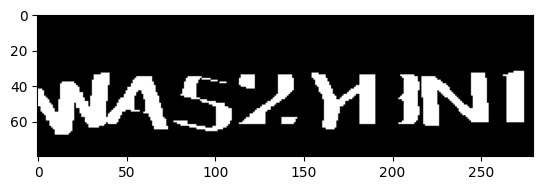

  2%|▏         | 162/8010 [03:33<35:11,  3.72it/s]

Skipping wa52ybn1-0.png due to length mismatch: 8 != 6


 11%|█         | 860/8010 [06:28<42:51,  2.78it/s]

error img:


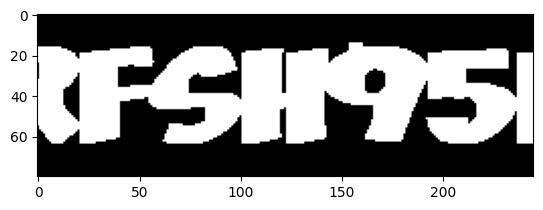

 11%|█         | 861/8010 [06:28<43:46,  2.72it/s]

Skipping rfsh95f-0.png due to length mismatch: 7 != 3


 24%|██▍       | 1933/8010 [11:04<23:06,  4.38it/s]

error img:


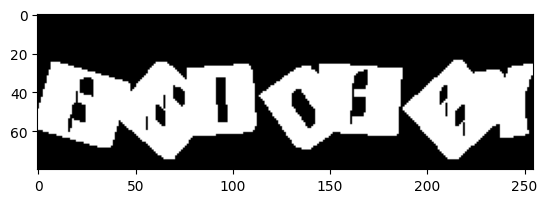

 24%|██▍       | 1934/8010 [11:05<24:02,  4.21it/s]

Skipping 70do56y-0.png due to length mismatch: 7 != 3


100%|██████████| 8010/8010 [37:01<00:00,  3.61it/s]

Number of failed cases:10
Fail rate:0.0006629541235746487


In [ ]:
if __name__ == "__main__":
    # Process each file in the input directory
    tokenizer = 'contours'
    # tokenizer = 'projection'

    input_dir = "/content/drive/MyDrive/cs4243_group_folder/code/mini_project/train"
    output_dir = f"{output_dir}_{tokenizer}"
    # Ensure output directory exists
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    charcount = {}
    for filename in tqdm(os.listdir(input_dir)):
        if filename.endswith(".png"):
            process_image(os.path.join(input_dir, filename), filename, charcount, tokenizer, output_dir)

    print(f"Number of failed cases:{fail}")
    percentage = fail / total
    print(f"Fail rate:{percentage}")

In [22]:
# Google Drive may fail to batch-process many files
# Back-up source before running this cell, or run this cell locally.
source = "/content/drive/MyDrive/cs4243_group_folder/code/processed_contours_contours/"
destination = "/content/drive/MyDrive/cs4243_group_folder/code/train_segmented/"

prepare_image_folder(source, destination)